## Lesson 11 / Lesson 12:
### Exercise: The transient universe 

### `MCMC`:

In [4]:
import emcee
import numpy as np
from matplotlib import pyplot as plt
import scipy as scipy
from scipy import stats
from tqdm.notebook import tqdm
import corner
import seaborn as sns
from astroML.stats import median_sigmaG
%config InlineBackend.figure_format='retina'
c = sns.color_palette('rocket', 5)

In [5]:
file = np.load('transient.npy')

In [6]:
time = file[:, 0]
flux = file[:, 1]
errors = file[:, 2]

In [7]:
# Burst + exponential tail model definition
def burst_f (x, par): # par is a vector containing the 4 parameters characterizing the burst function
    b, A, t_0, alfa = par
    burst = b + A * np.exp(-alfa*(x-t_0))  
    return np.where(x < t_0, b, burst)

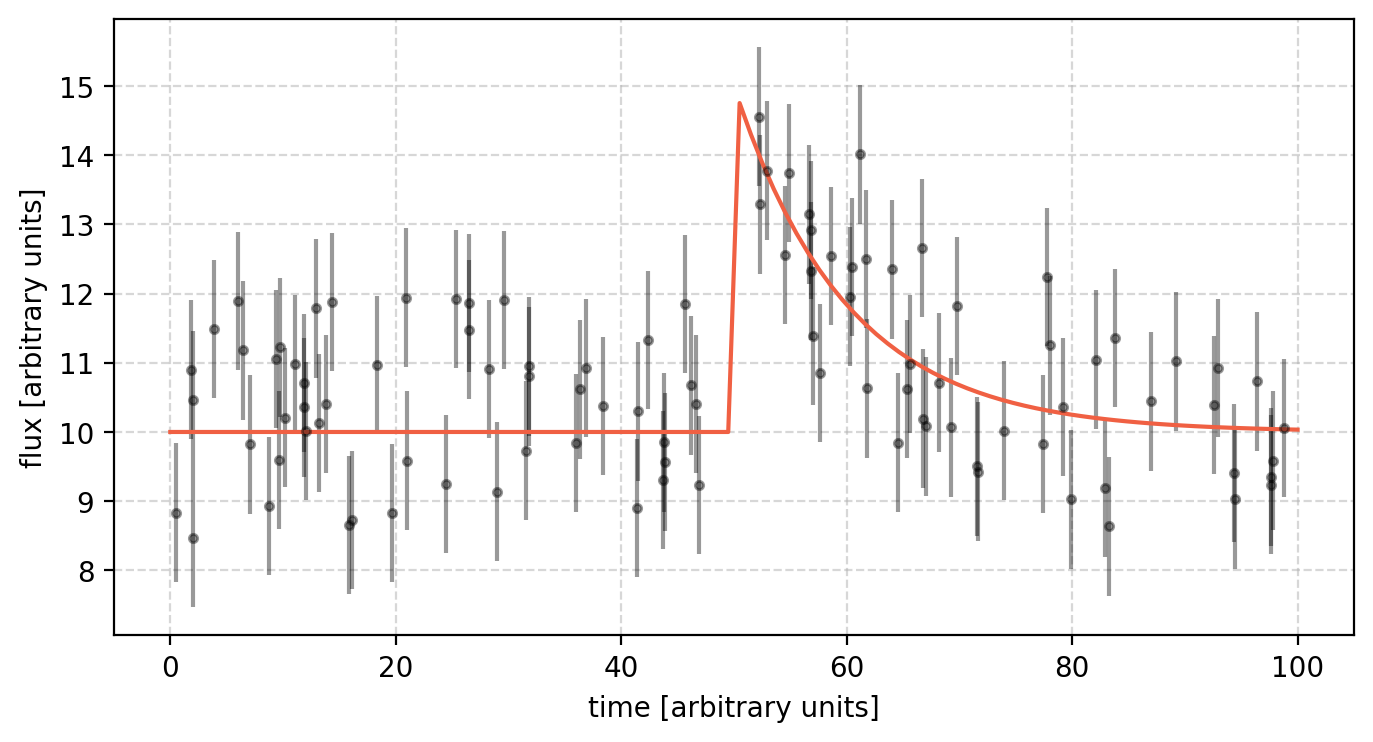

In [8]:
fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
xgrid = np.linspace(0, 100, 100)

par_guesses = (10, 5, 50, 0.1)

ax.set_xlabel('time [arbitrary units]')
ax.set_ylabel('flux [arbitrary units]')
ax.errorbar(time, flux, yerr=errors, fmt=".", c='black', alpha=0.4)
ax.plot(xgrid, burst_f(xgrid, par_guesses), color=c[3])

ax.grid(True, ls='--', alpha=0.5)

### Defining the likelihood, prior and posterior distributions

We can make the assumption of *gaussianly distributed* data, so that the likelihood can be computed as follows (As we saw in *Lecture 6*):

$$L = \prod_{i=1}^N p(t_i | y_i, M(t_i, \theta), \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \prod_{i=1}^N \exp\Big(-\frac{(y_i - M(t_i,\theta))^2}{2\sigma^2}\Big)$$

$$\ln{L} = \ln\Big(\frac{1}{\sqrt{2\pi\sigma^2}}\Big) - \frac{1}{2}\sum_{i=1}^{N} \frac{(y_i - M(t_i,\theta))^2)}{\sigma^2}$$

where:

$M(t, \theta) = M(t, b, A, t_0, \alpha) = $

>$b$, for $t<t_0$

>$b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

In [9]:
t = np.copy(time)
data = np.copy(flux)
sigma = np.copy(errors)

In [10]:
def LogLikelihood(par):
    model = burst_f(t, par)
    f = (1/sigma**2)*(data - model)**2 
    return (-0.5)*np.sum(f) #Neglecting the const

def Prior(par):
    #uniform prior in (b, A, t_0, log(alpha))
    prior_b = stats.uniform.pdf(par[0], loc=0, scale=50)
    prior_A = stats.uniform.pdf(par[1], loc=0, scale=50)
    prior_t0 = stats.uniform.pdf(par[2], loc=0, scale=100)
    prior_alpha = stats.loguniform.pdf(par[3], np.exp(-5), np.exp(5))
    
    return  prior_b * prior_A * prior_t0 * prior_alpha

def LogPosterior(par):
    
    lprior =  np.log(Prior(par))
    if not np.isfinite(lprior):
        return -np.inf
    else:
        return LogLikelihood(par) + lprior

> `emcee` uses multiple walkers to explore the posterior distribution. We set an initial guess for the parameter (or parameters) for each of those walkers

In [11]:
nwalkers = 15
ndim = 4
burn = 400
nsteps = 10000

In [41]:
# We initialize the parameters
guesses = np.array([10, 5, 50, 0.1])
starting_guesses = guesses + np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps, progress=True) 

print('done')

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_120389/3667719099.py:17: RuntimeWarning: divide by zero encountered in log
  lprior =  np.log(Prior(par))
100%|████████████████████████████████████| 10000/10000 [00:36<00:00, 273.10it/s]

done


### Trace-plots

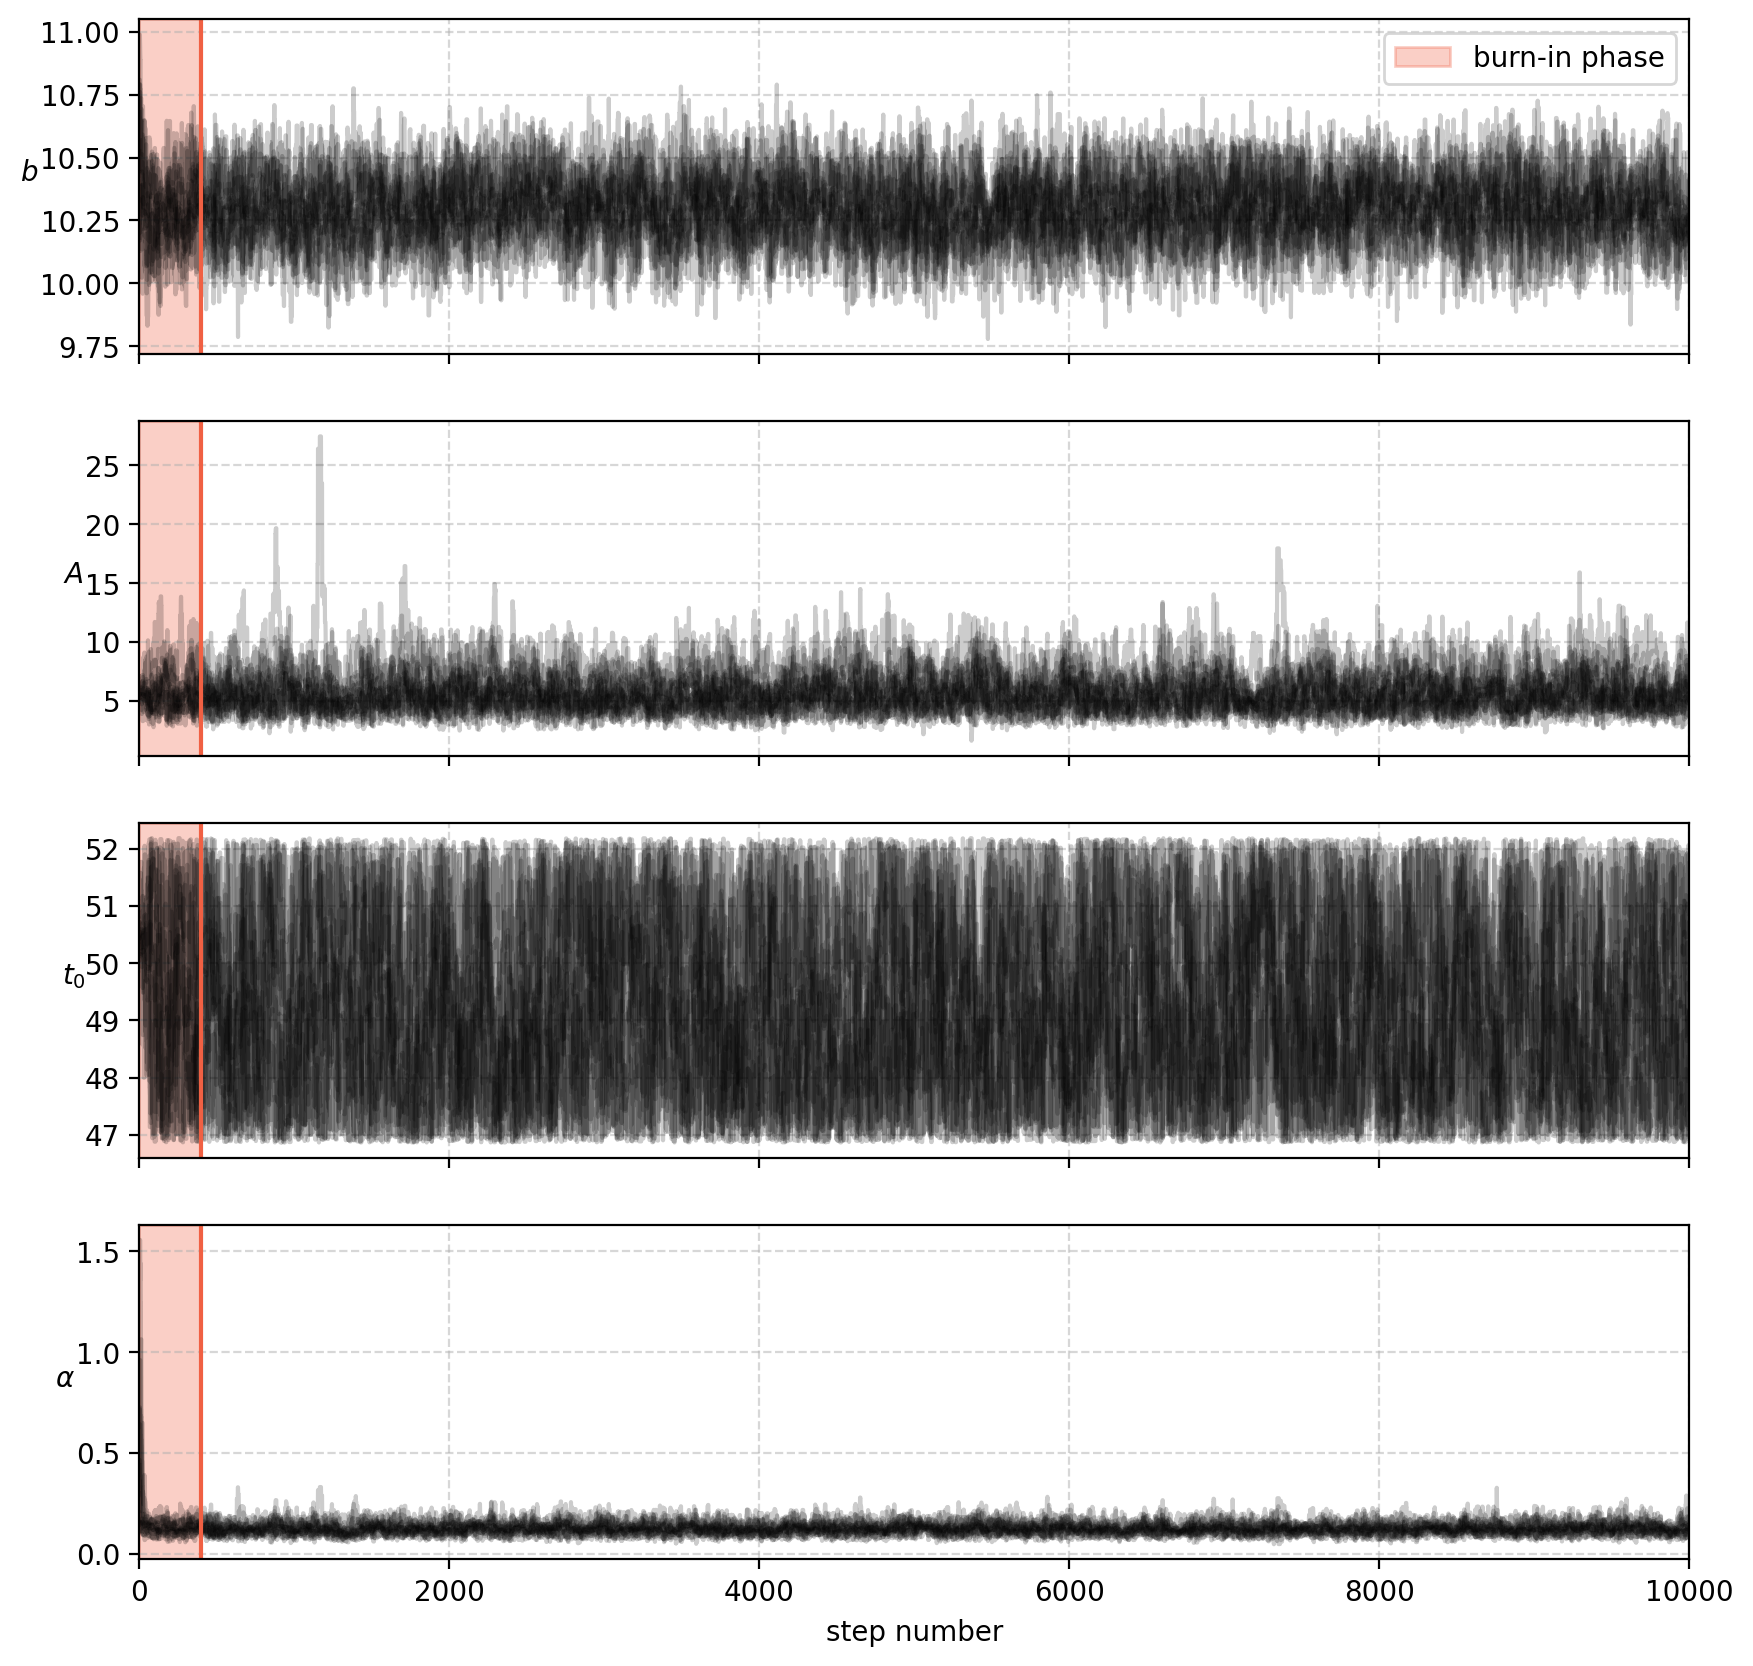

In [42]:
fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)
samples = sampler.get_chain() #not thinned nor "de-burned"

labels = [r"$b$",r"$A$", r"$t_0$", r"$\alpha$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], 'k', alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], rotation=0)
    ax.grid(True, ls='--', alpha=0.5)
    ax.axvline(burn, color=c[3])
    ax.axvspan(0, burn, color=c[3], alpha=0.3, label=f'burn-in phase')
    
    
axes[-1].set_xlabel("step number");
axes[0].legend(frameon=True, loc='upper right')

#### Removing *Burn-in phase* and thinning the chain every autocorrelation length

In [14]:
tau = sampler.get_autocorr_time()
print(tau)
thin_tau = int(np.mean(tau))
print(thin_tau)

[57.50561666 75.79285422 87.19177498 57.97211837]
69


In [15]:
samples = sampler.get_chain(discard=burn, thin=thin_tau, flat=False)
flat_samples = sampler.get_chain(discard=burn, thin=thin_tau, flat=True)

(2085, 4)


### Corner plot

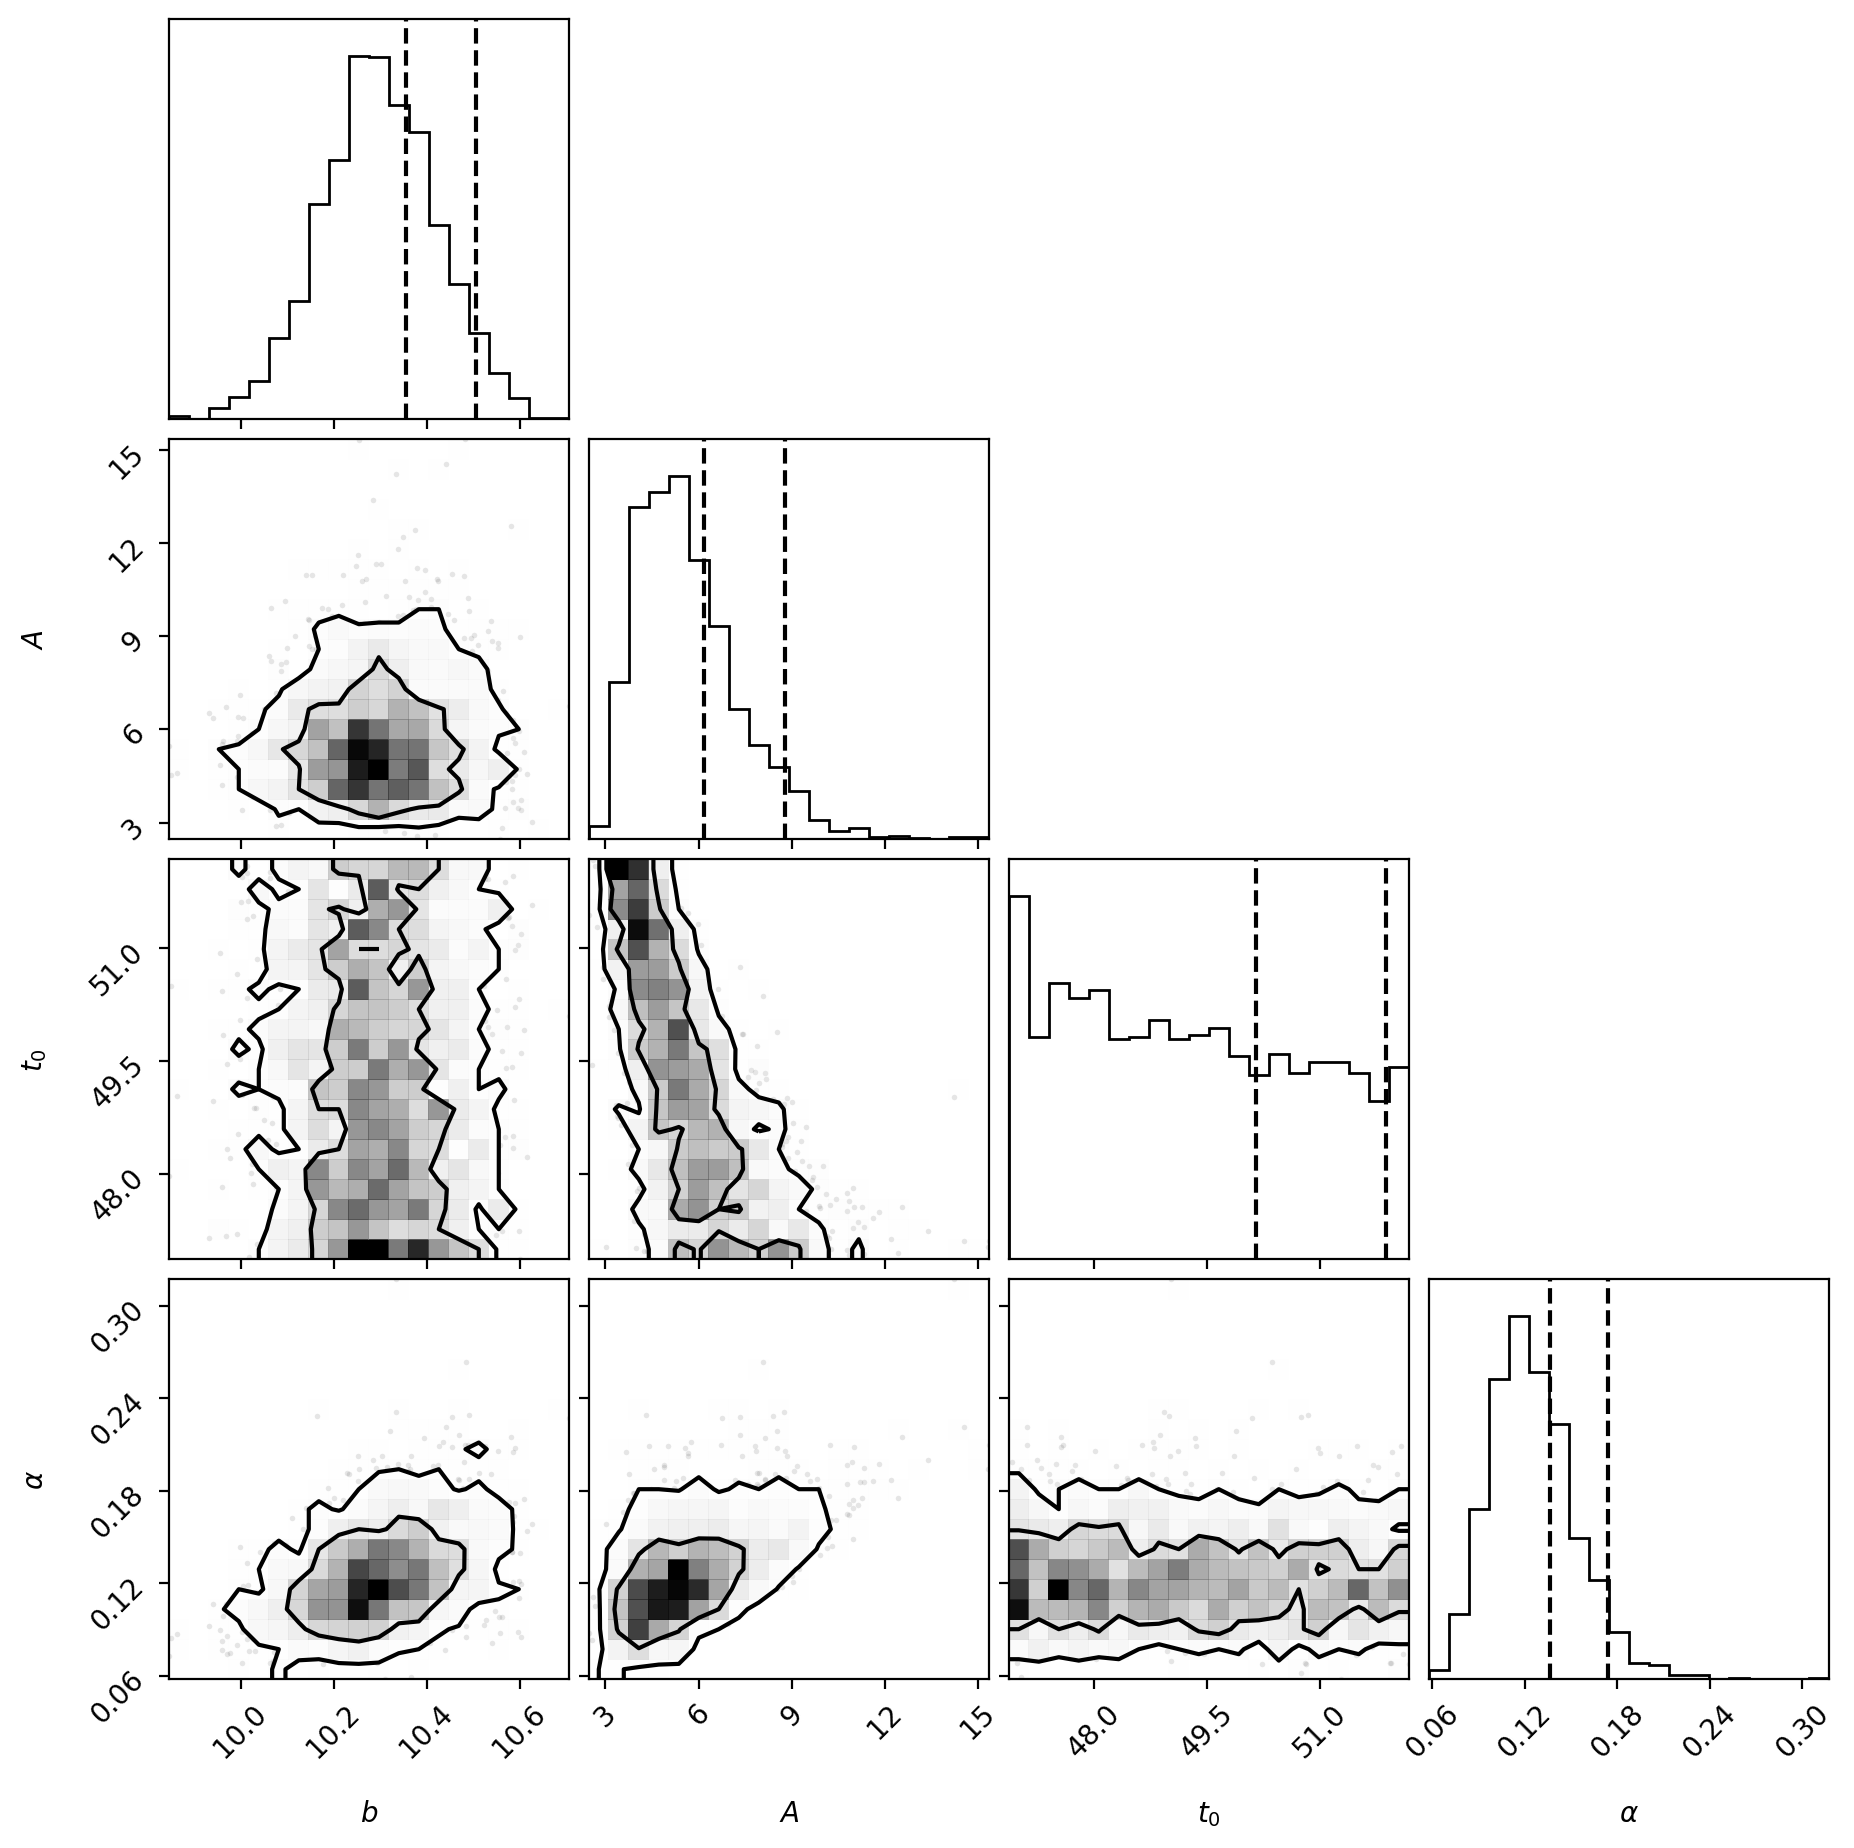

In [16]:
fig = corner.corner(flat_samples, labels=labels, levels=[0.68,0.95], quantiles=[0.68, 0.95]);

---

### Extract 100 random samples from the chain for parameter estimation:

In [17]:
rng = np.random.default_rng()
rand_samples = rng.choice(flat_samples, size=100)

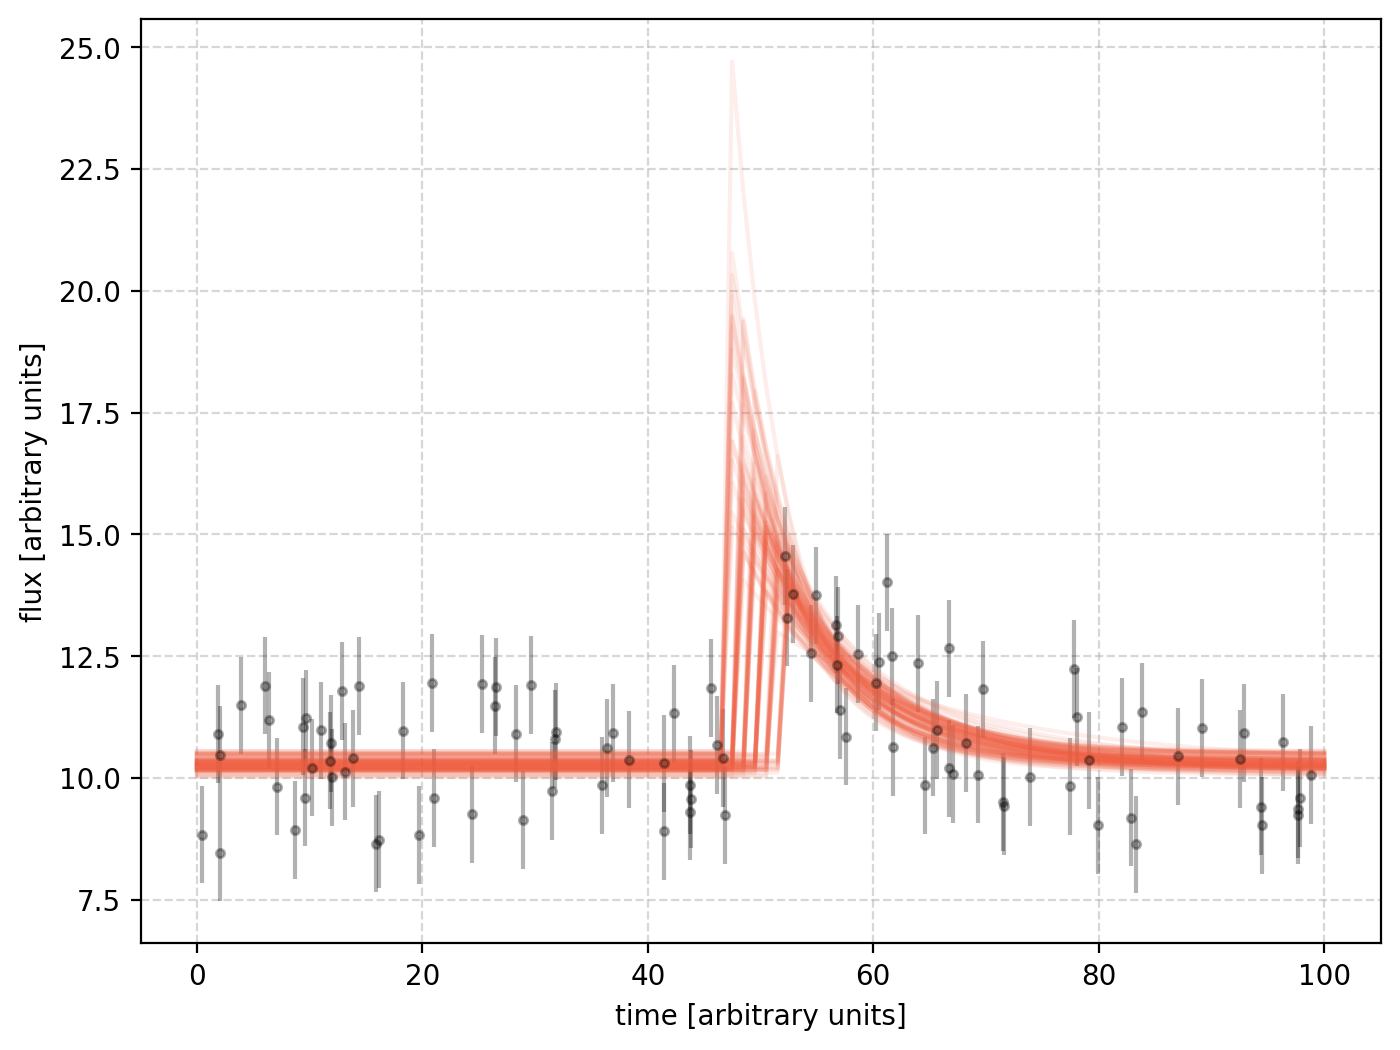

In [18]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
xgrid = np.linspace(0, 100, 100)

ax.set_xlabel('time [arbitrary units]')
ax.set_ylabel('flux [arbitrary units]')
ax.errorbar(time, flux, yerr=errors, fmt=".", c='black', alpha=0.3)

for sample in rand_samples:
    ax.plot(xgrid, burst_f(xgrid, sample), color=c[3], alpha=0.1)
ax.grid(True, ls='--', alpha=0.5)

In [19]:
medians = median_sigmaG(rand_samples, axis=0)
medians = [val for val in medians]

print(medians[0]) #The medians for the parameters

upper_bounds = np.percentile(rand_samples[:, :], 95, axis=0) - medians[0]
lower_bounds = medians[0] - np.percentile(rand_samples[:, :], 5, axis=0)

[10.27755152  5.25637344 49.23247484  0.11709051]


In [20]:
for count, value in enumerate(labels):
    print(r"Best estimate of %s"%value[1:-1], "is: ", round(medians[0][count], 2), "+", round(upper_bounds[count], 2), "-", 
         round(lower_bounds[count], 2))

Best estimate of b is:  10.28 + 0.22 - 0.17
Best estimate of A is:  5.26 + 4.25 - 1.55
Best estimate of t_0 is:  49.23 + 2.81 - 2.25
Best estimate of \alpha is:  0.12 + 0.06 - 0.03


---
### `Nested Sampling`:

Another possible model that may explain the data is a Gaussian profile described by:

$$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$$

In [21]:
def gauss_f (x, par): # par is a vector containing the 4 parameters characterizing the burst function
    b, A, t_0, sig_W = par
    func = b + A * np.exp(-((x-t_0)**2)/(2*sig_W**2))  
    return func

In [22]:
par_guesses = (10, 5, 50, 5)

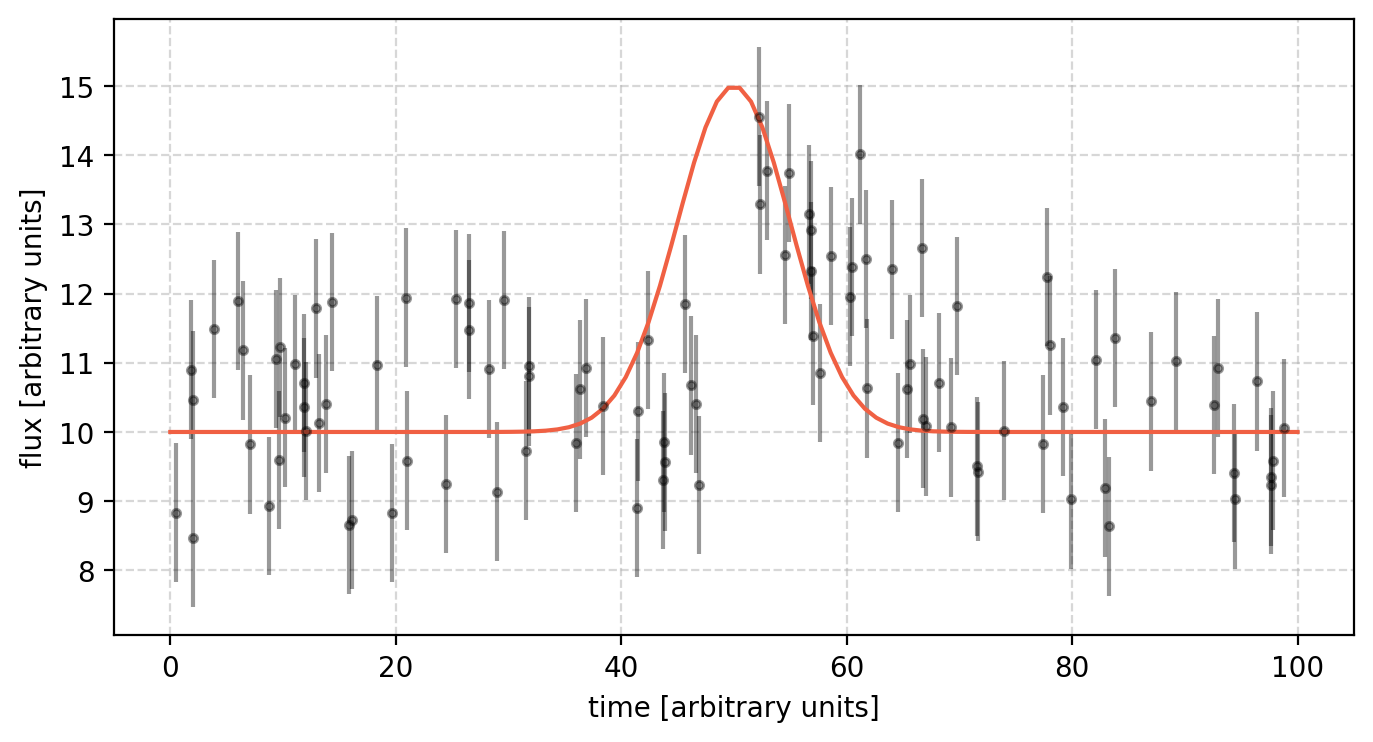

In [23]:
fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
xgrid = np.linspace(0, 100, 100)

ax.set_xlabel('time [arbitrary units]')
ax.set_ylabel('flux [arbitrary units]')
ax.errorbar(time, flux, yerr=errors, fmt=".", c='black', alpha=0.4)
ax.plot(xgrid, gauss_f(xgrid, par_guesses), color=c[3])

ax.grid(True, ls='--', alpha=0.5)

$$\ln{L} = \ln\Big(\frac{1}{\sqrt{2\pi\sigma^2}}\Big) - \frac{1}{2}\sum_{i=1}^{N} \frac{(y_i - M(t_i,\theta))^2)}{\sigma^2} = -\frac{1}{2}\ln{(2\pi\sigma^2)} - \frac{1}{2}\sum_{i=1}^{N} \frac{(y_i - M(t_i,\theta))^2)}{\sigma^2}$$

In [24]:
#Prior ranges for 4 parameters:
a1, b1 = 0, 20 #b
a2, b2 = 0, 20 #A
a3, b3 = 30, 70 #t_0
a4, b4 = 0, 10 #sig_W

def transform_prior(u):
    # Define the ranges for each parameter
    ranges = [(a, b) for a, b in zip([a1, a2, a3, a4], [b1, b2, b3, b4])]
    params = [a + (b - a) * ui for (a, b), ui in zip(ranges, u)]
    
    return params

def LogLikelihood_gauss(par): #Now we care about the normalizing constant!
    model = gauss_f(t, par)
    f = (1/sigma**2)*(data - model)**2 
    return (-0.5) * np.log(2*np.pi*sigma[0]**2) - 0.5 * np.sum(f) #I choose sigma[0] since errors are all the equal!

def LogLikelihood_burst(par): #Now we care about the normalizing constant!
    model = burst_f(t, par)
    f = (1/sigma**2)*(data - model)**2 
    return (-0.5) * np.log(2*np.pi*sigma[0]**2) - 0.5 * np.sum(f)

### Bayesian evidence - Gaussian model

In [25]:
import dynesty

sampler = dynesty.NestedSampler(LogLikelihood_gauss, transform_prior, ndim)
sampler.run_nested()
sresults = sampler.results

2557it [00:02, 575.46it/s, bound: 6 | nc: 4 | ncall: 22194 | eff(%): 11.521 | loglstar:   -inf < -88.160 <    inf | logz: -95.357 +/-  0.113 | dlogz: 34.889 >  0.509]     /home/nicolofiaba/.local/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/nicolofiaba/.local/lib/python3.10/site-packages/dynesty/bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using m

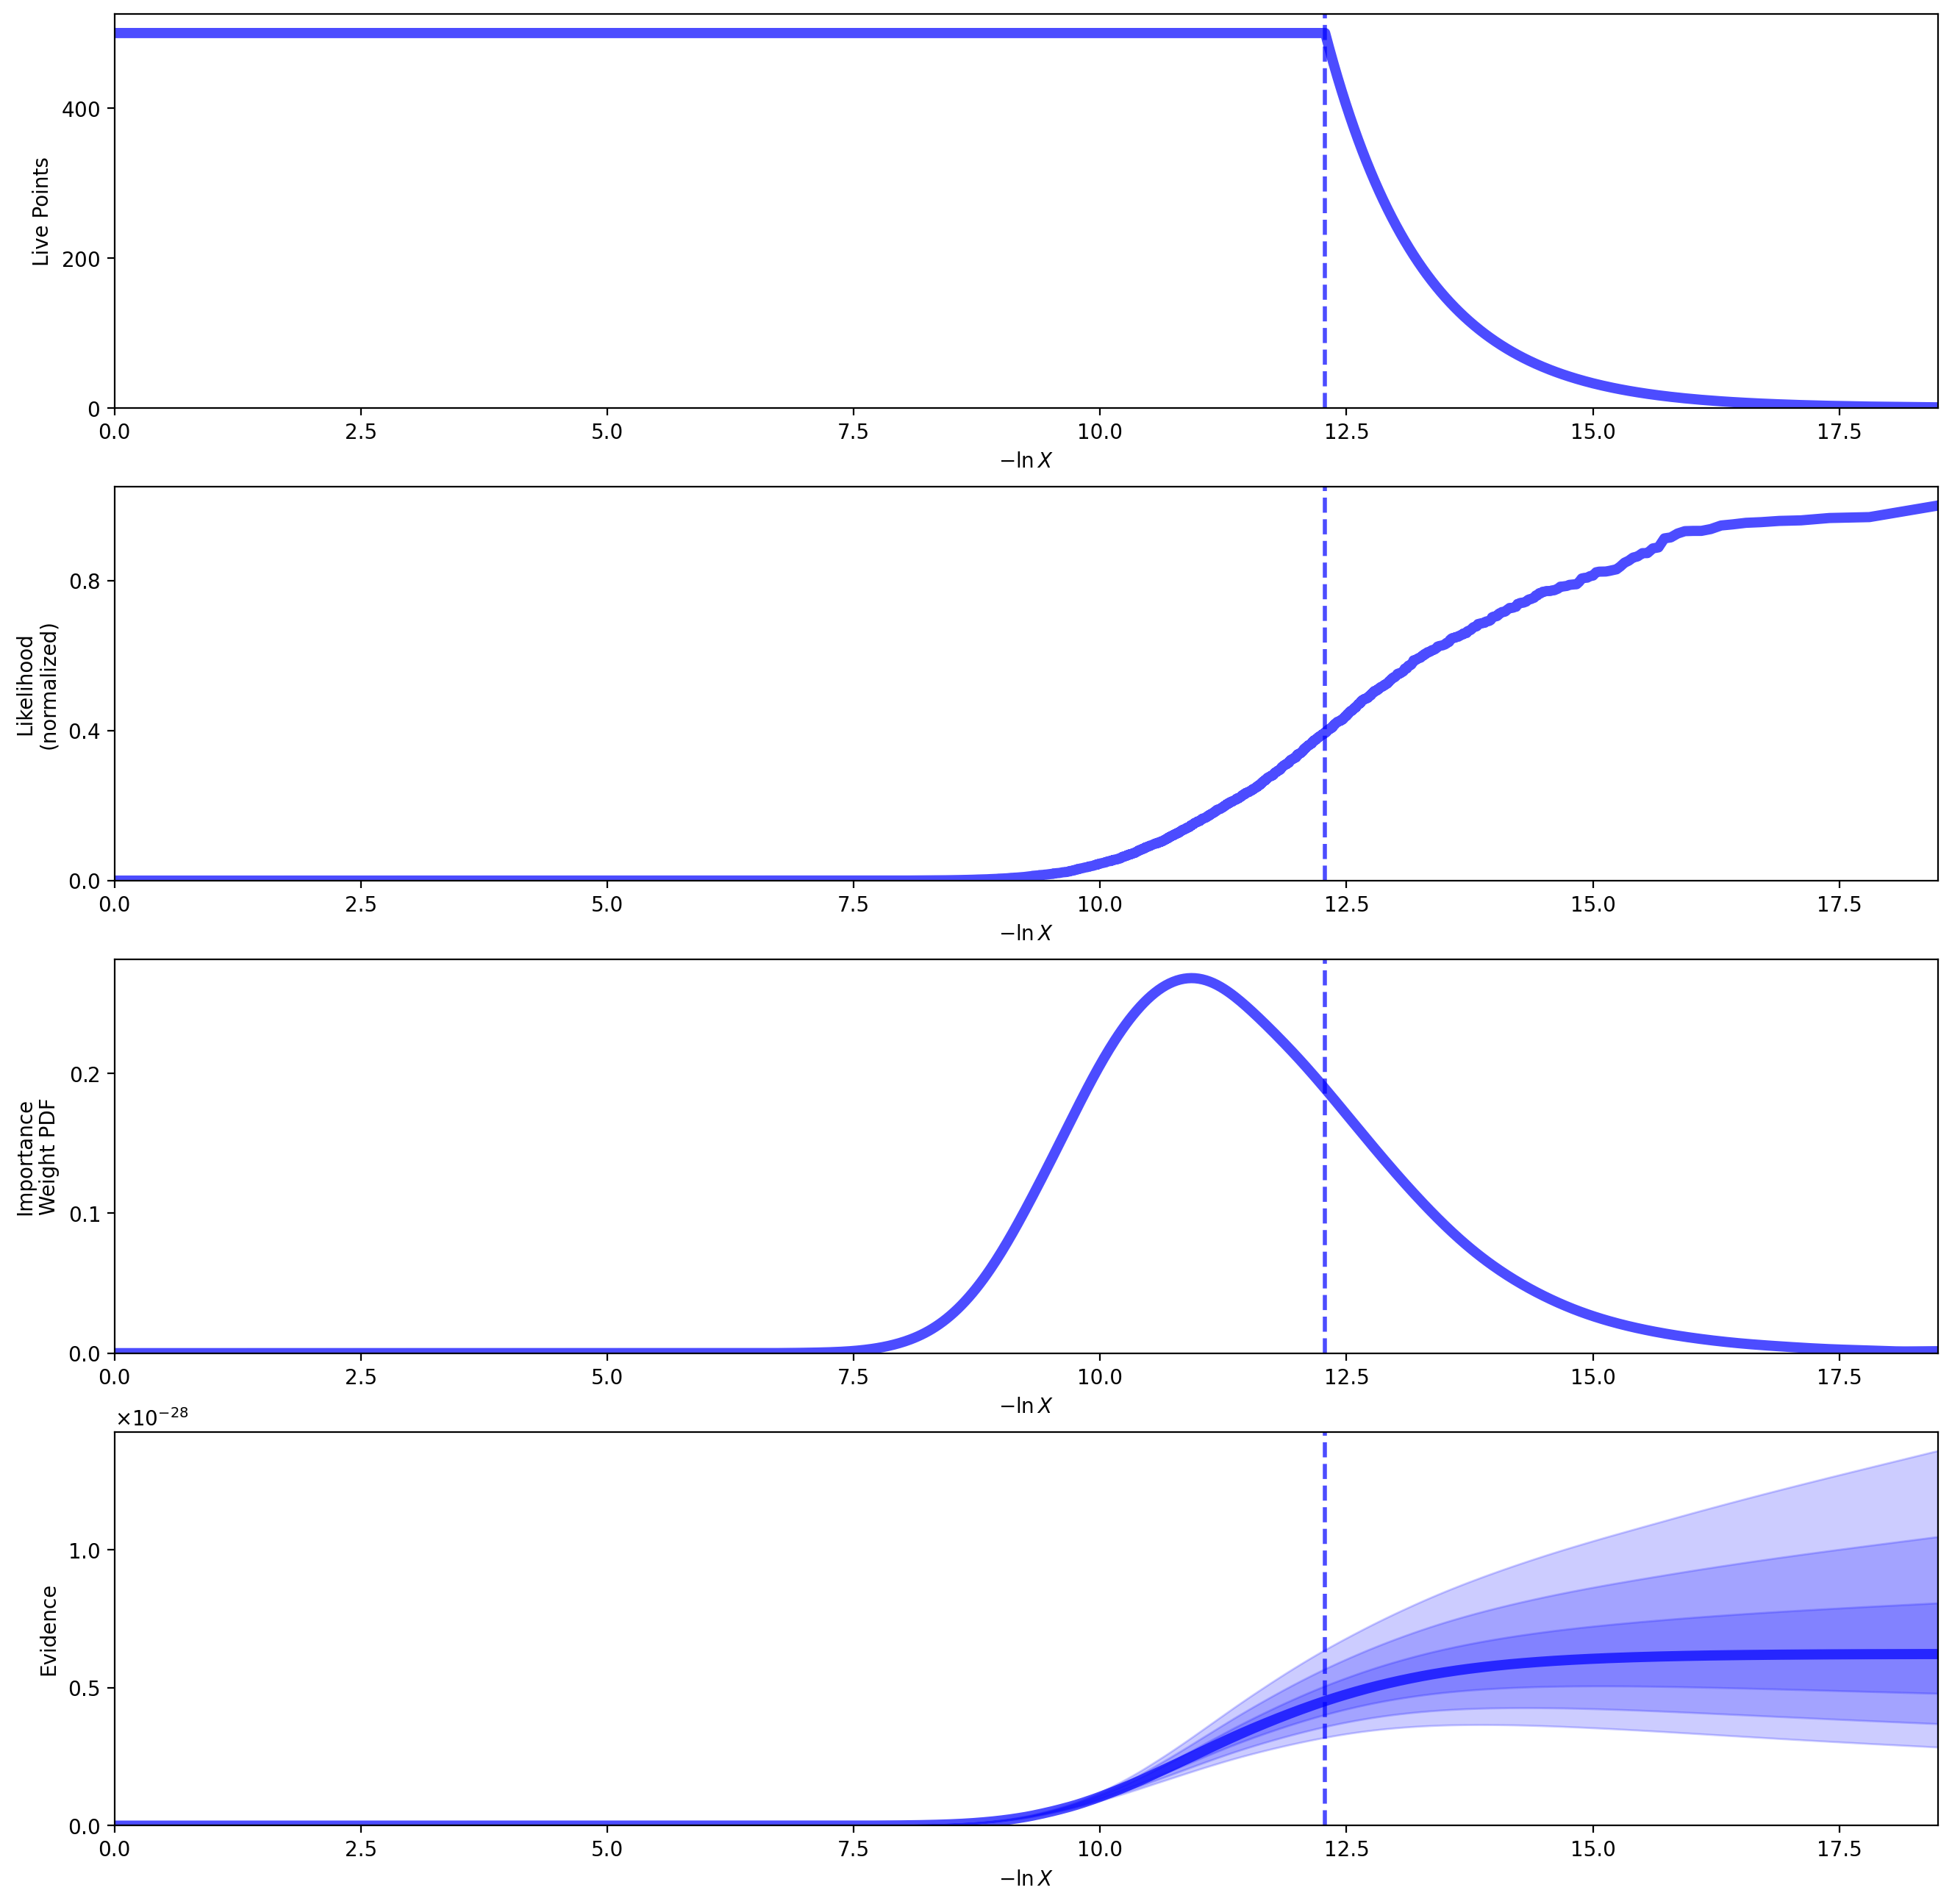

In [26]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

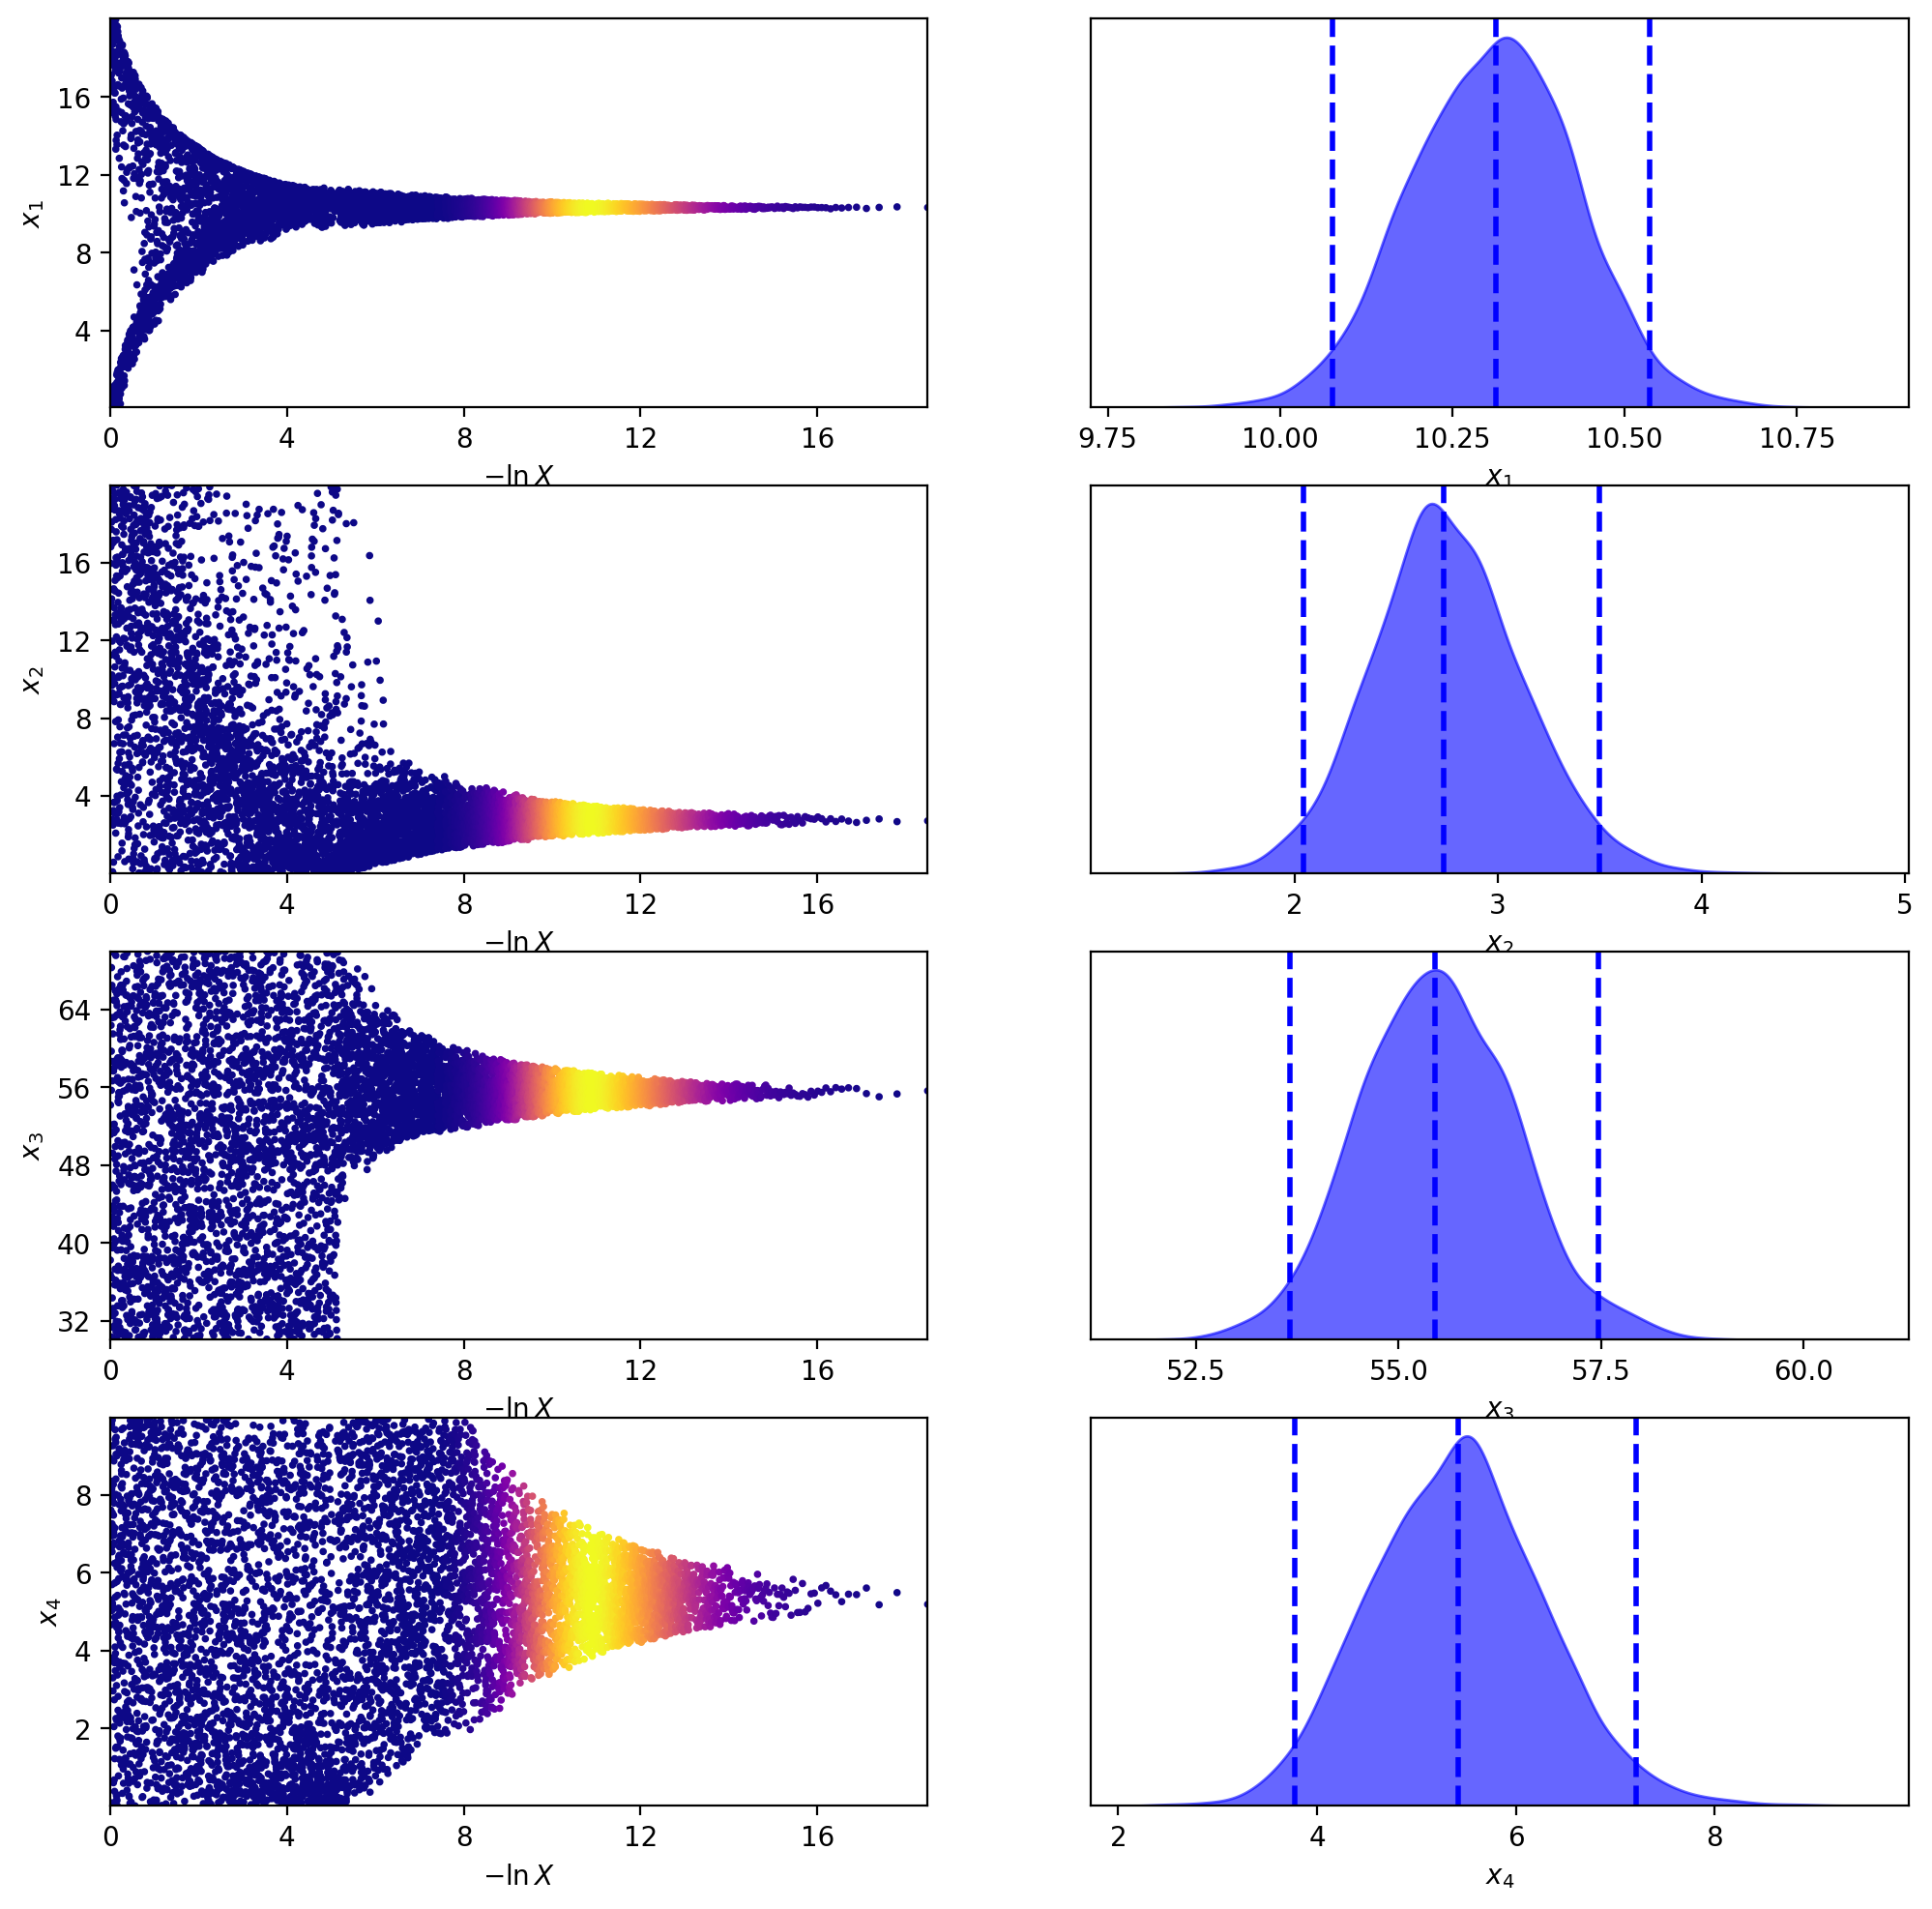

In [27]:
tfig, taxes = dyplot.traceplot(sresults)

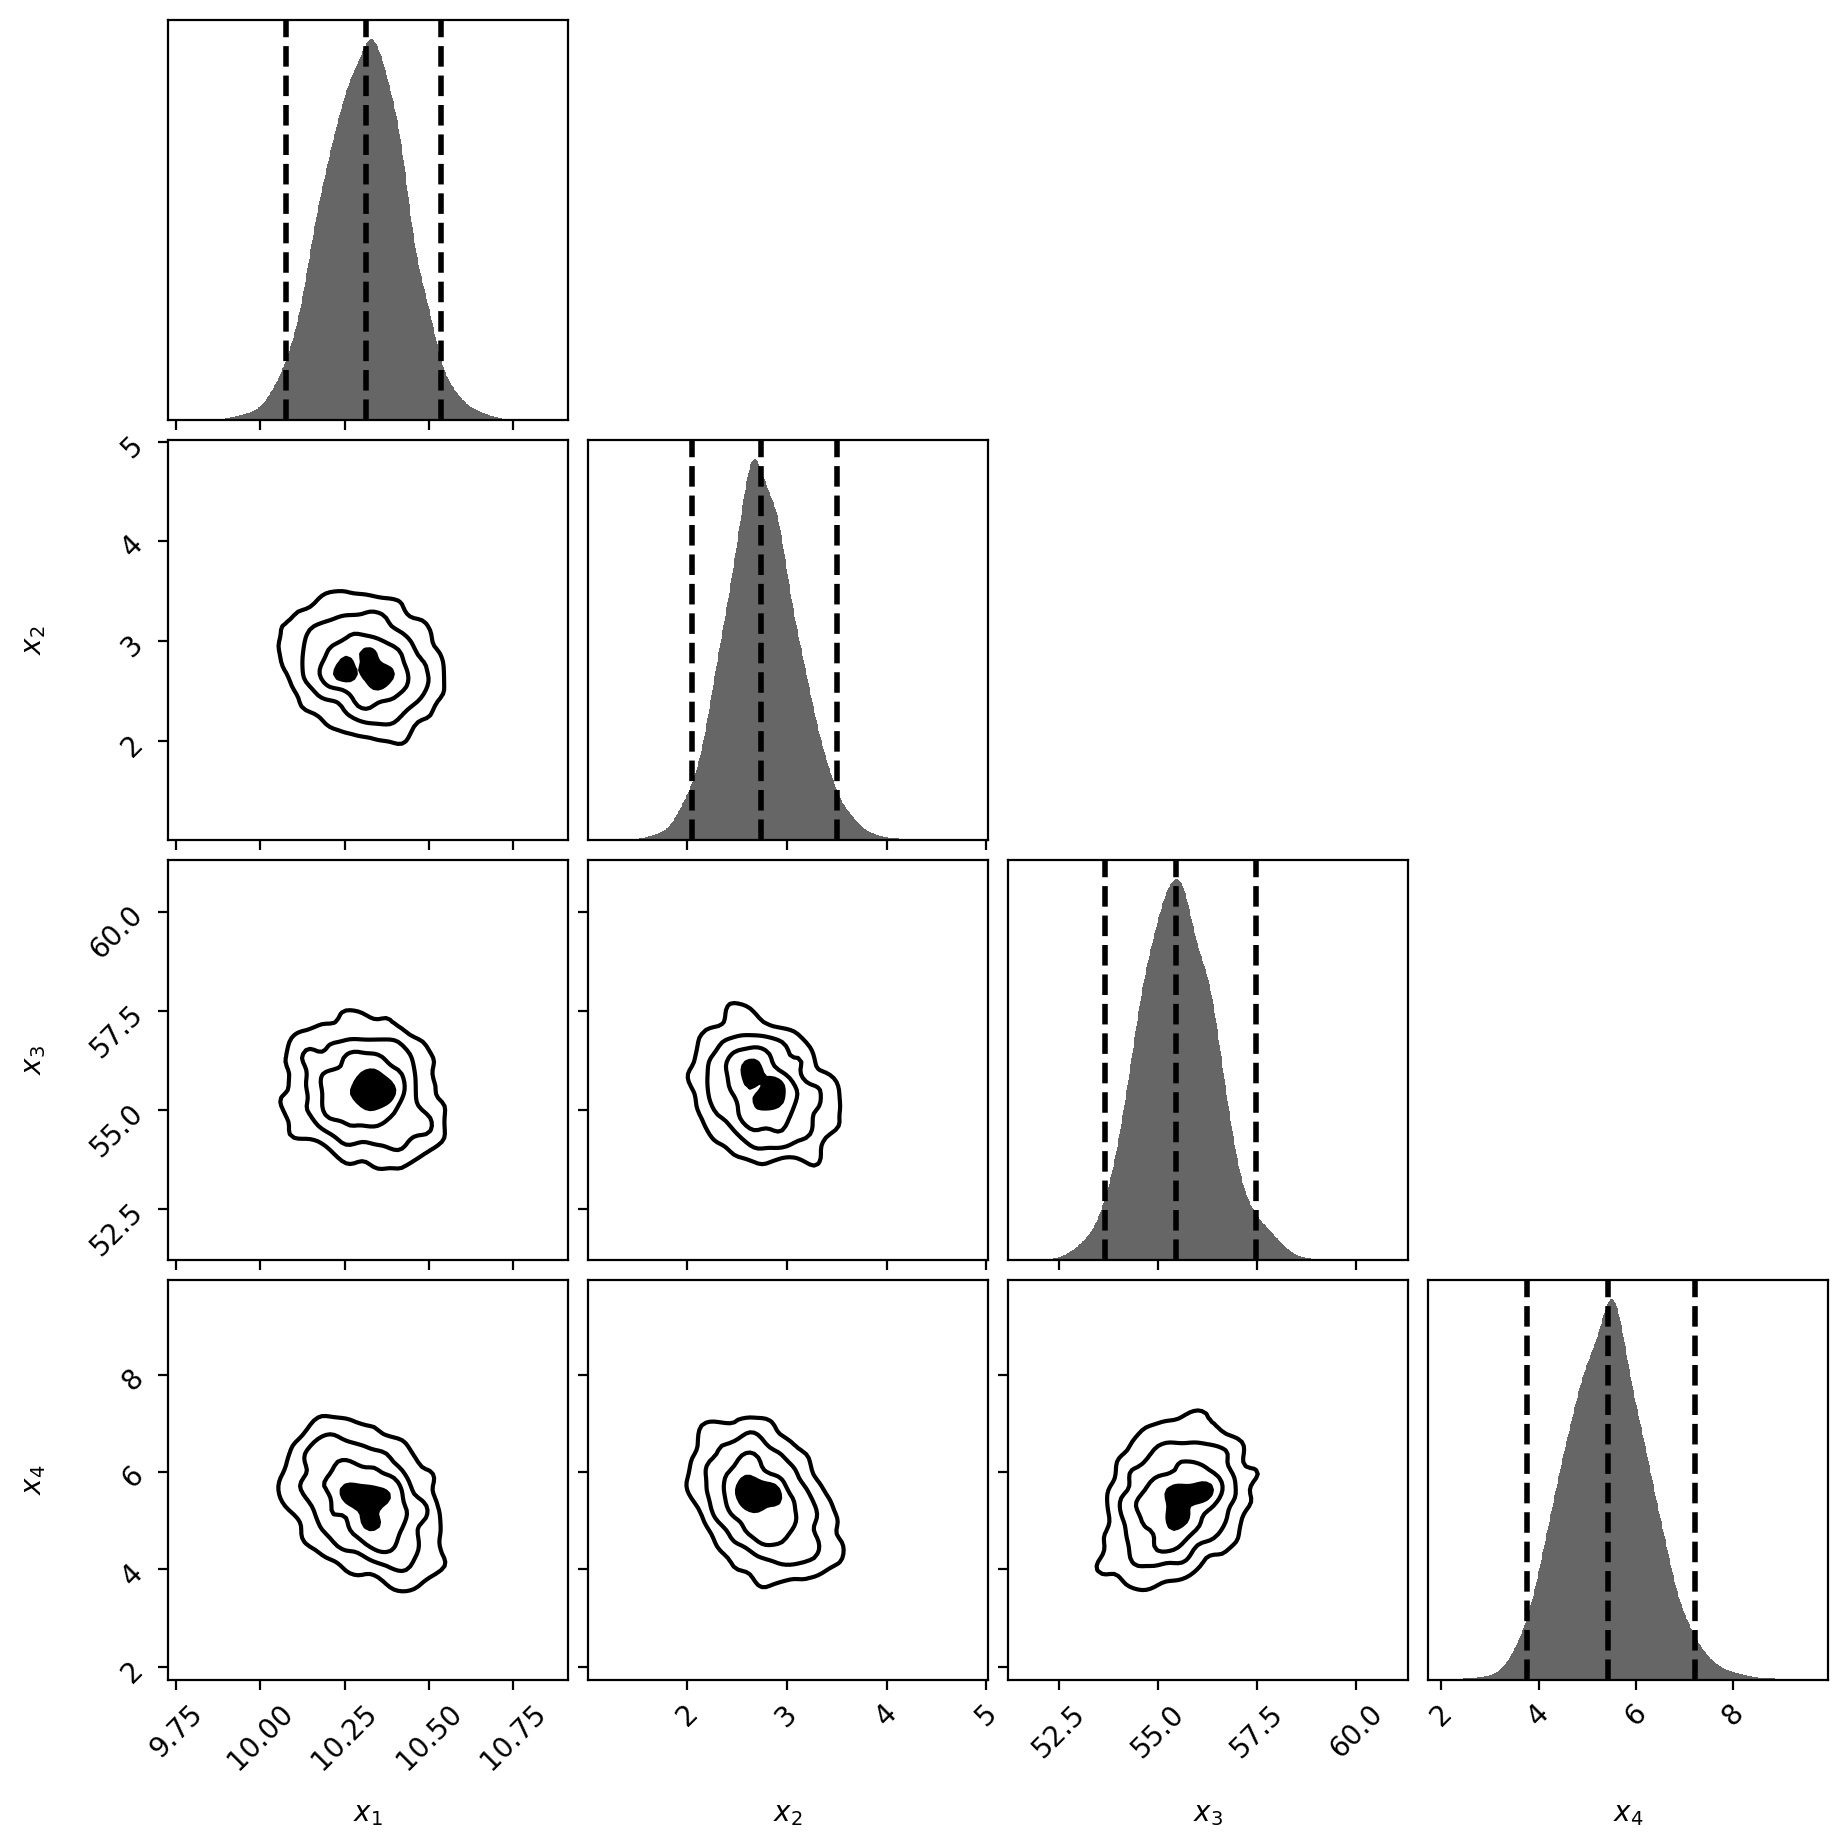

In [28]:
cfig, caxes = dyplot.cornerplot(sresults)

In [29]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

evidence_gauss = np.exp(sresults.logz[-1]) #evidence
print("Bayesian evidence", evidence_gauss)

quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: \n' + str(mean) + '\n\n' + str(cov))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

Bayesian evidence 6.221297328503421e-29
68% parameter credible regions are:
 [[10.187348707740753, 10.425724502786876], [2.3931319038008483, 3.1197823642129943], [54.528092750388645, 56.43106229952725], [4.529391700502492, 6.264403773380045]]

Mean and covariance of parameters are: 
[10.3092507   2.75037599 55.47879963  5.4168953 ]

[[ 0.01426107 -0.00819142 -0.01845165 -0.04004308]
 [-0.00819142  0.13616141 -0.11131549 -0.13652614]
 [-0.01845165 -0.11131549  0.93142287  0.26508848]
 [-0.04004308 -0.13652614  0.26508848  0.76800321]]


NB: remember to downweight your samples before using `corner`. **dynesty** yields weighted samples. If you use dynesty tool for corner plots this is not necessary.

### Bayesian evidence - burst model

NB: We've used the same prior function even if now the 4th parameter has changed. Using the original prior $(e^{-5}, e^5)$ results in overflow errors with `dynesty`.

MCMC gives an estimate for $\alpha$ of 0.12, so $(0, 10)$ is still a reasonable prior. 

In [30]:
sampler_2 = dynesty.NestedSampler(LogLikelihood_burst, transform_prior, ndim)
sampler_2.run_nested()
sresults_2 = sampler_2.results

7302it [00:20, 349.44it/s, +500 | bound: 97 | nc: 1 | ncall: 90657 | eff(%):  8.654 | loglstar:   -inf < -49.674 <    inf | logz: -63.493 +/-  0.164 | dlogz:  0.001 >  0.509]


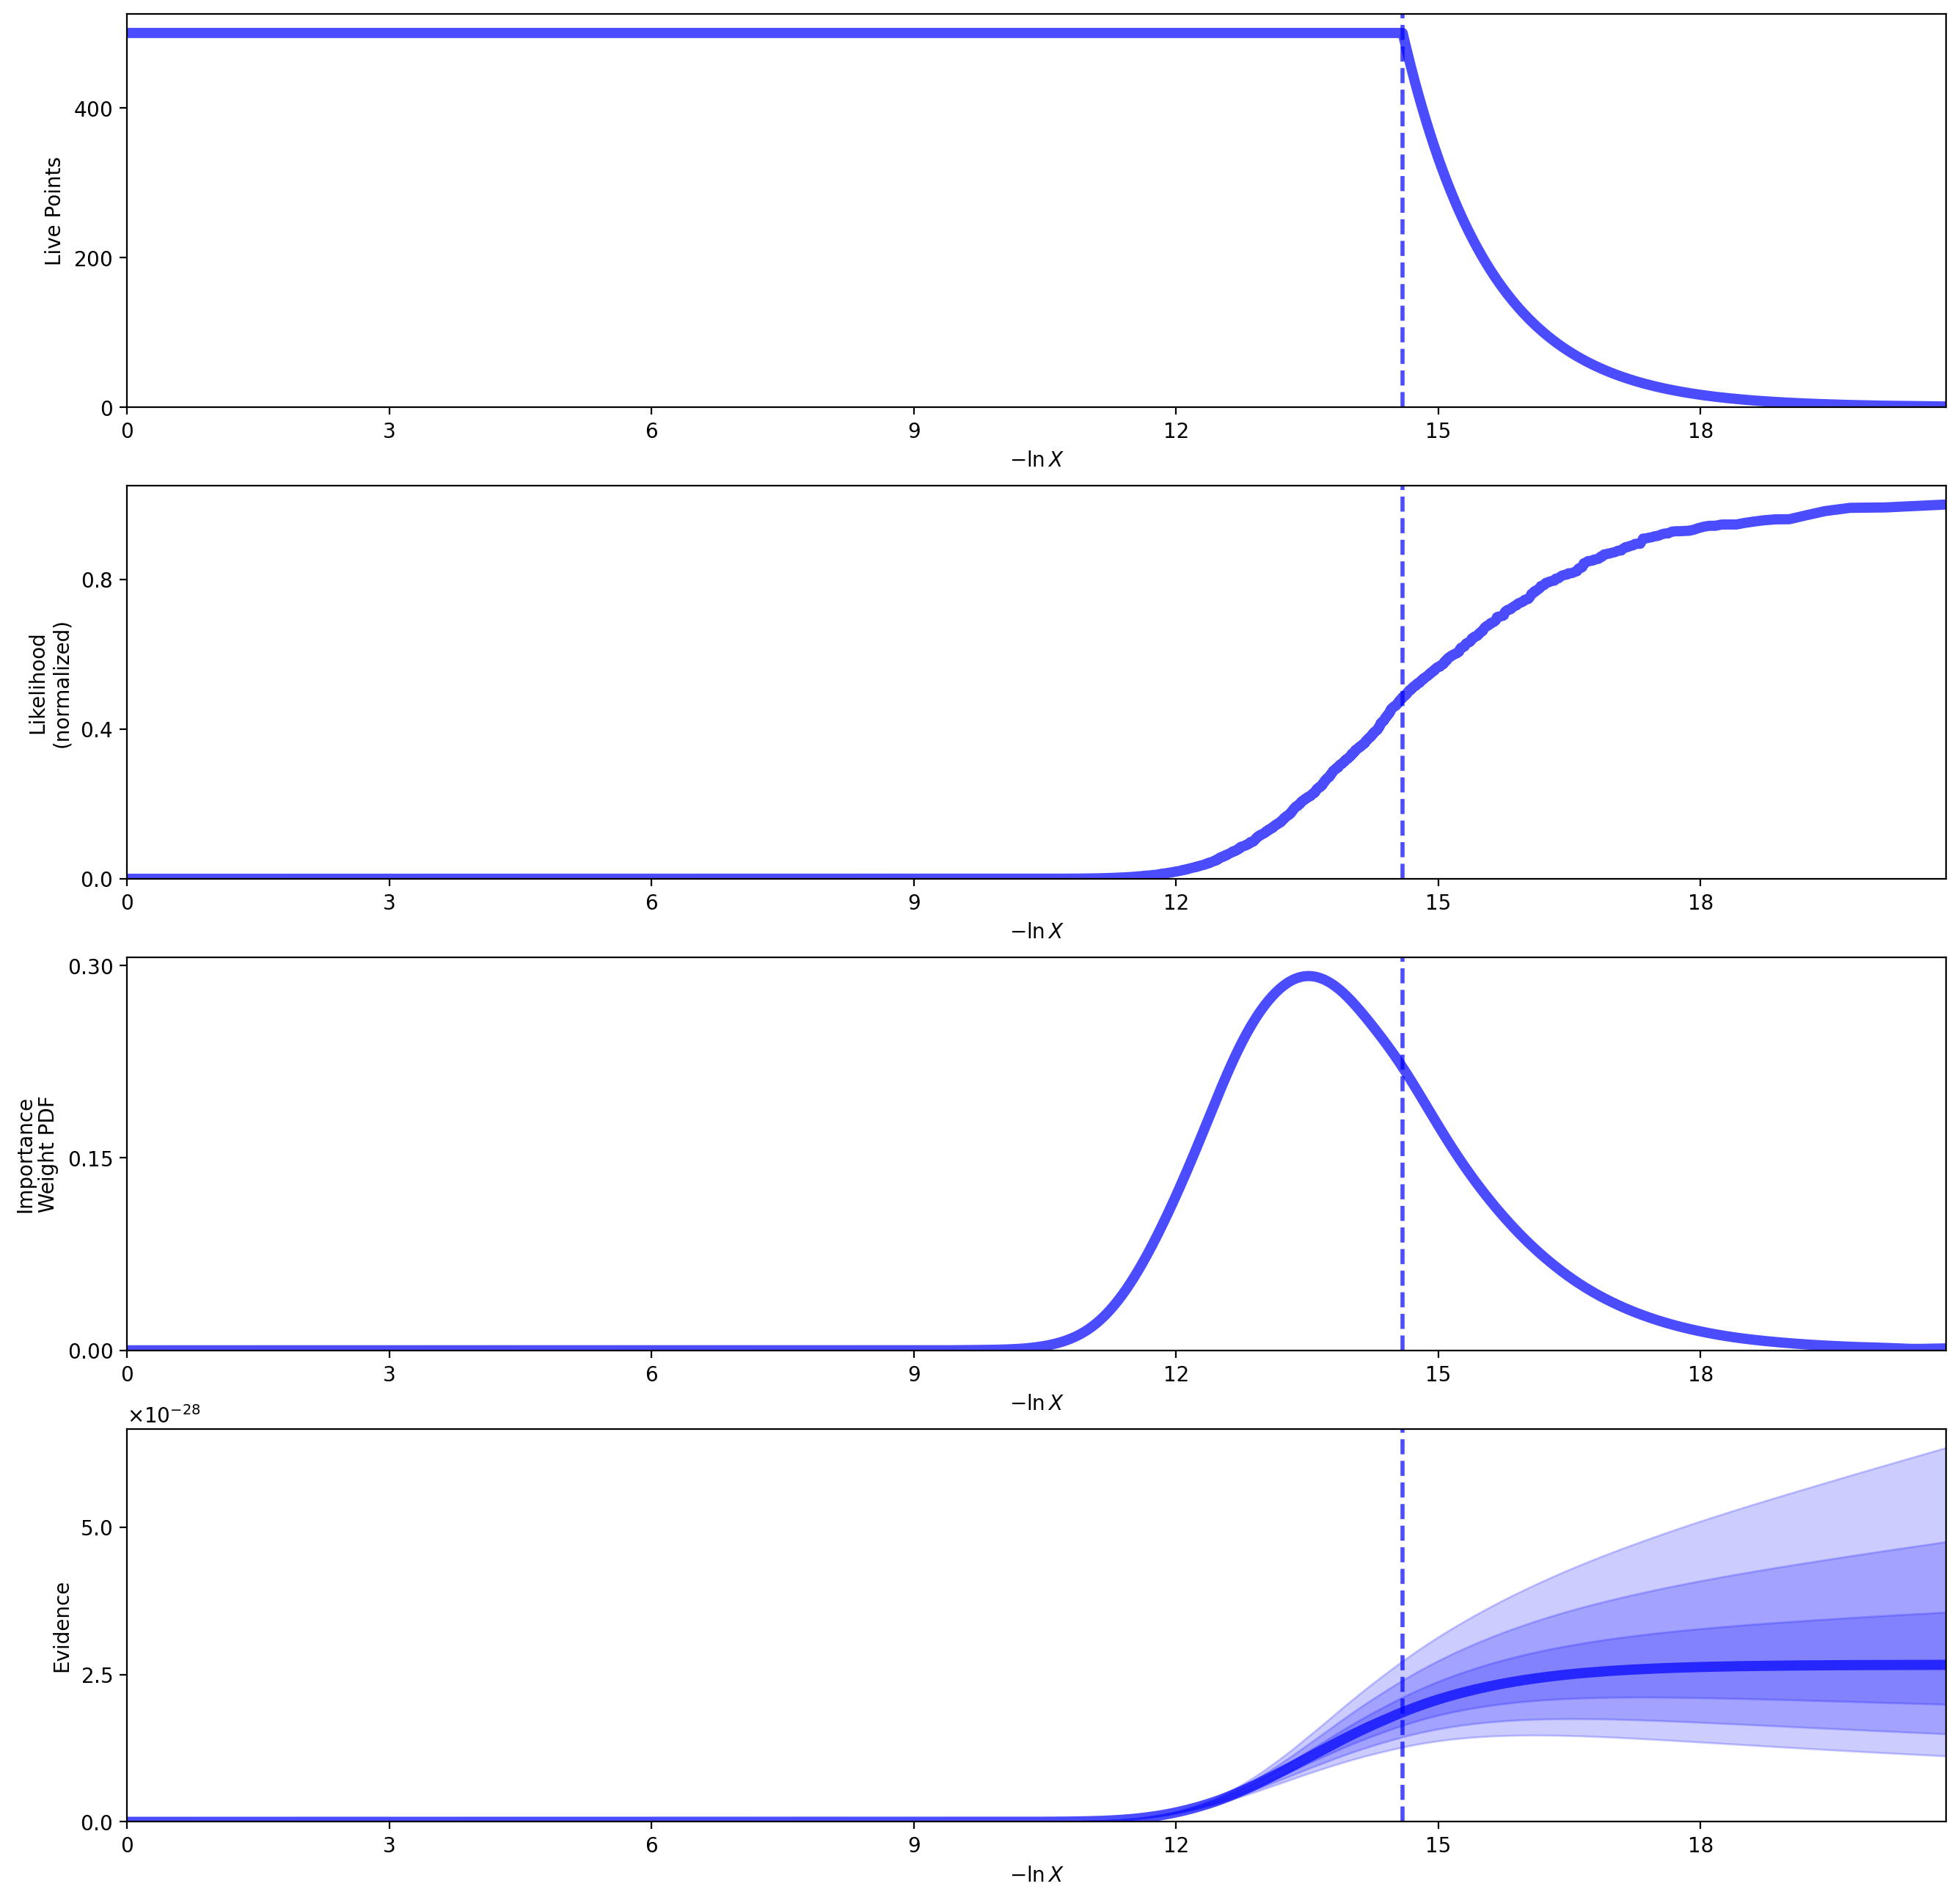

In [31]:
rfig, raxes = dyplot.runplot(sresults_2)

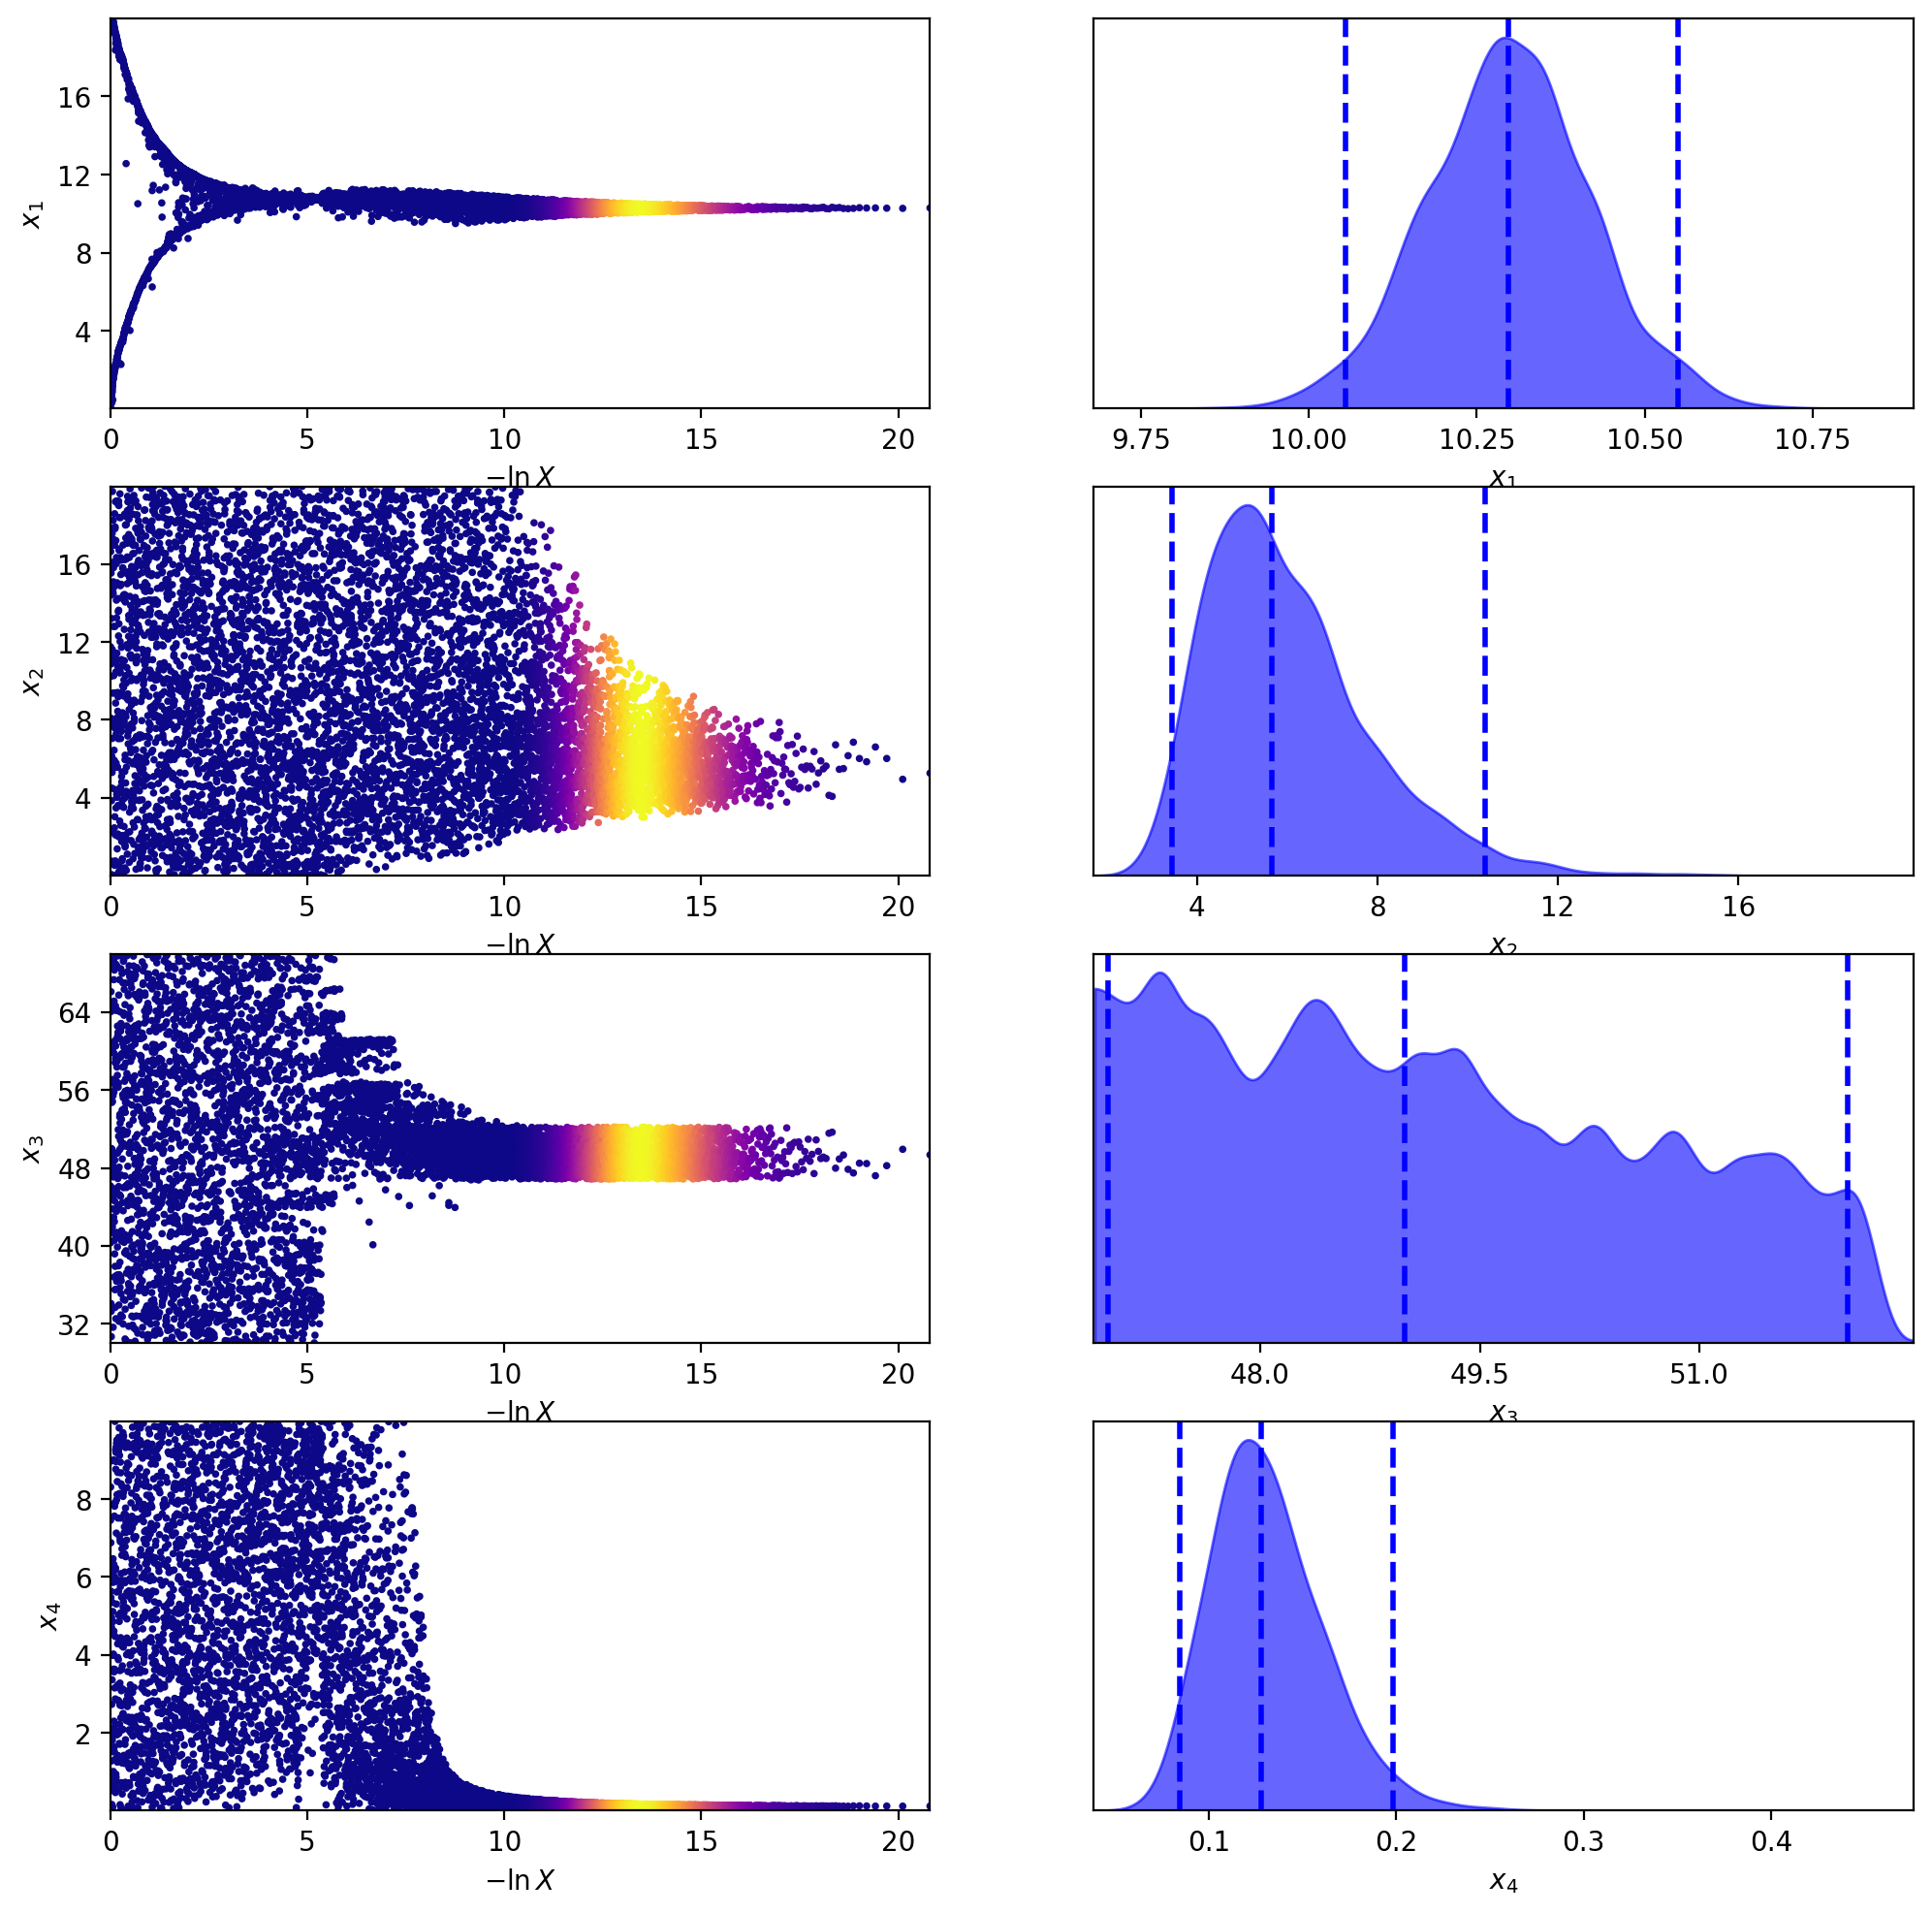

In [32]:
tfig, taxes = dyplot.traceplot(sresults_2)

In [33]:
evidence_burst = np.exp(sresults_2.logz[-1]) #evidence
print("Bayesian evidence of burst model is:", evidence_burst)

Bayesian evidence of burst model is: 2.66295926542287e-28


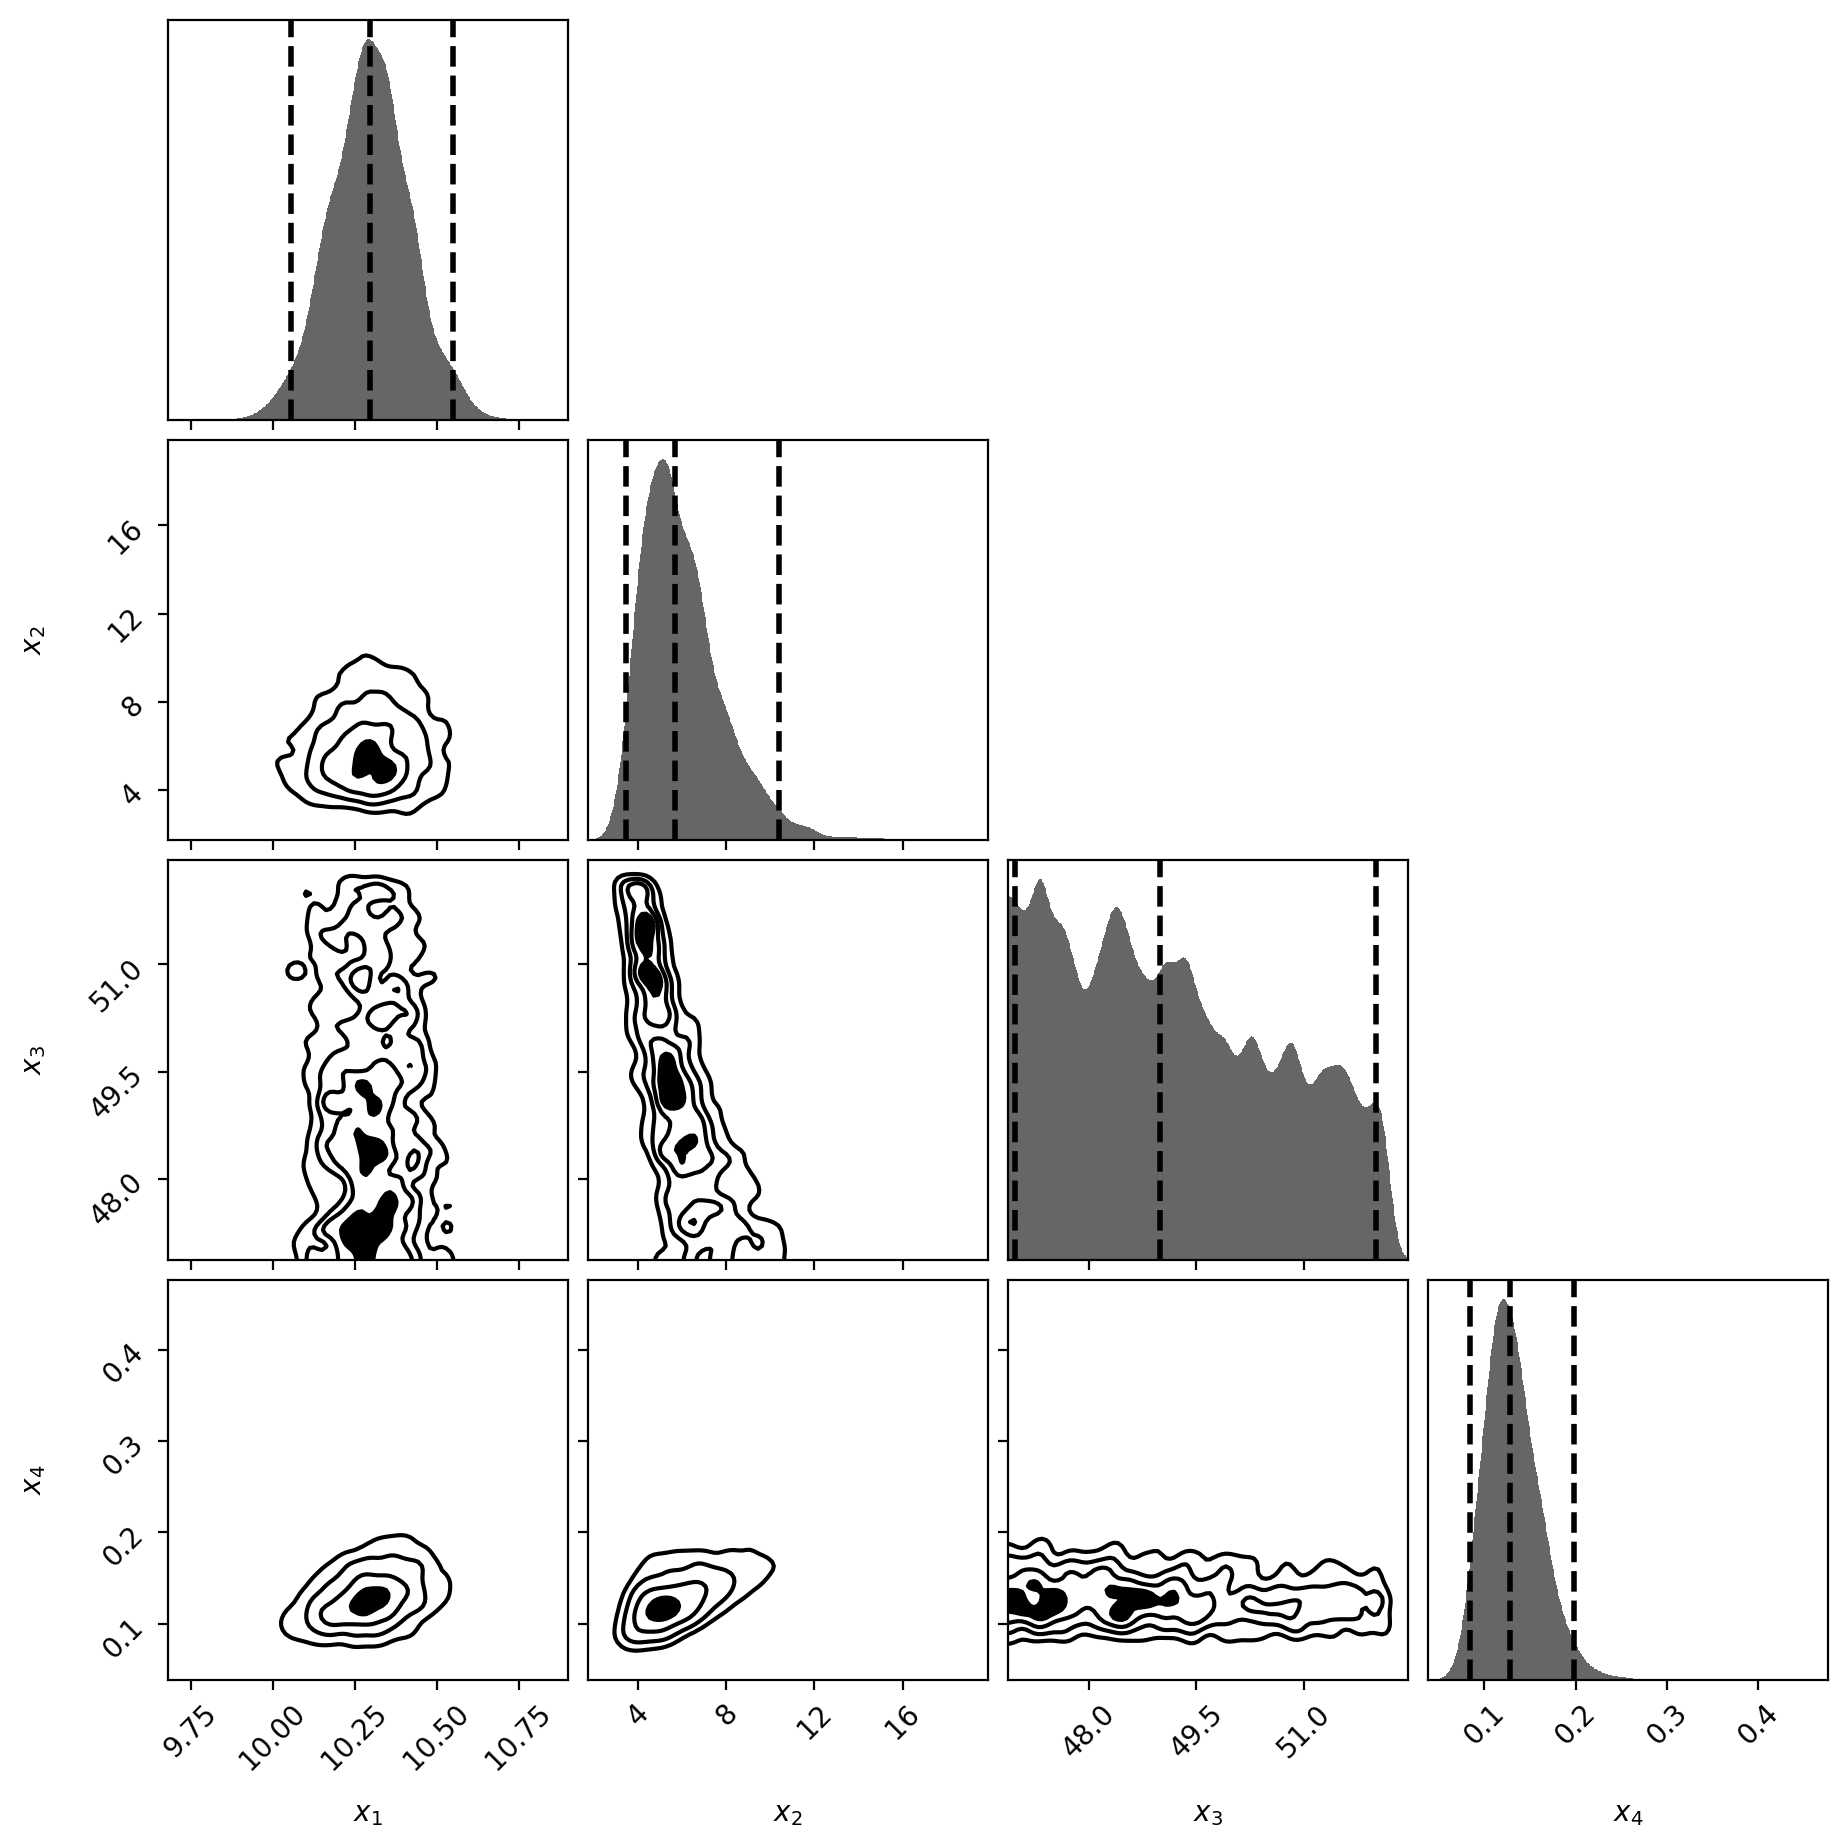

In [34]:
cfig, caxes = dyplot.cornerplot(sresults_2)

We notice that the `corner` plot for the **burst model** is qualitatively similar to the one we obtained using MCMC sampling.

### Bayes factor estimation
Assuming:
- Model 1: Burst
- Model 2: Gaussian

We can estimate the Bayes factor $\mathcal{B}_{12}$ to perform a model selection:

$$\mathcal{B}_{12} = \frac{\mathcal{Z}_1}{\mathcal{Z}_2} $$

In [39]:
B_12 = evidence_burst/evidence_gauss
print("B_12 = %.3f"%B_12)

B_12 = 4.280


In [36]:
print("ln(B_12) = %.3f"%np.log(B_12))

ln(B_12) = 1.454


According to Jeffreys scale, a Bayes factor such that $1.1 < \ln{\mathcal{B_{12}}} < 2.3$ is sign of a *substantial* preference for model 1 over model 2. Thus we can conclude that the favored description of our data is given by the **burst model**.

---

In [37]:
sresults.summary()

Summary
nlive: 500
niter: 6147
ncall: 42948
eff(%): 15.477
logz: -64.947 +/-  0.261


In [38]:
sresults_2.summary()

Summary
nlive: 500
niter: 7302
ncall: 90157
eff(%):  8.654
logz: -63.493 +/-  0.290
